# Analisi dati Opencoesione

Esecuzione di analisi della banca dati Opencoesione circa i progetti relativi al ciclo di programmazione 2014/2020 aventi come tema sintetico quello della *Ricerca ed innovazione".

## Gruppo di lavoro:

* Lanciotti Antonio
* Di Gaetano Anna
* Olivieri Davide
* D'Agostino Lorenzo

### Target: Regione Marche
Andranno individuati i progetti che ricadono nelle aree tematiche della S3 regionale e di Impresa 4.0 (*leggere [README](https://github.com/LorenzoDag/Economia#readme)*)

### Import librerie ed inizializzazione sessione

In [251]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace # Bisogna sostituire le ',' con '.' nei numeri altrimenti il casting fallisce
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.appName("Economia").getOrCreate()

### Upload dataset
**Nota**: Cambiare i path

In [252]:
path_localizzazioni = "hdfs://localhost:9000/localizzazioni.csv"
path_progetti = "hdfs://localhost:9000/progetti.csv"
path_soggetti = "hdfs://localhost:9000/soggetti.csv"

localizzazioni = spark.read.option("delimiter", ";").option("header", True).csv(path_localizzazioni)
localizzazioni.createOrReplaceTempView("localizzazioni") # Rende la tabella visibile a spark (per query)
progetti = spark.read.option("delimiter", ";").option("header", True).csv(path_progetti)
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", regexp_replace("FINANZ_TOTALE_PUBBLICO", ",", "."))
progetti = progetti.withColumn("FINANZ_TOTALE_PUBBLICO", progetti["FINANZ_TOTALE_PUBBLICO"].cast(DoubleType())).fillna(0, subset=["FINANZ_TOTALE_PUBBLICO"])
progetti.createOrReplaceTempView("progetti")             # Rende la tabella visibile a spark (per query)
soggetti = spark.read.option("delimiter", ";").option("header", True).csv(path_soggetti)
soggetti.createOrReplaceTempView("soggetti")             # Rende la tabella visibile a spark (per query)

### Definizione e consecutiva esecuzione query
Seleziona le colonne descritte nel [README](https://github.com/LorenzoDag/Economia#readme) ed esegue una join on *COD_LOCALE_PROGETTO*

In [253]:
select_loc = "localizzazioni.COD_LOCALE_PROGETTO, localizzazioni.DEN_REGIONE, localizzazioni.DEN_PROVINCIA, localizzazioni.DEN_COMUNE, localizzazioni.INDIRIZZO_PROG"
select_prog = "progetti.OC_TITOLO_PROGETTO, progetti.OC_SINTESI_PROGETTO, progetti.DESCRIZIONE_GRANDE_PROGETTO, progetti.CUP_DESCR_CATEGORIA, progetti.CUP_DESCR_NATURA,progetti.CUP_DESCR_TIPOLOGIA,progetti.CUP_DESCR_SETTORE,progetti.CUP_DESCR_SOTTOSETTORE,progetti.OC_DATA_INIZIO_PROGETTO,progetti.FINANZ_TOTALE_PUBBLICO"
select_sogg = "soggetti.COD_ATECO_SOGG, soggetti.SOGG_DESCR_RUOLO, soggetti.OC_CODICE_FISCALE_SOGG, soggetti.OC_DENOMINAZIONE_SOGG, soggetti.INDIRIZZO_SOGG, soggetti.CAP_SOGG"

where_prog = "progetti.OC_COD_CICLO = 2 AND progetti.OC_COD_TEMA_SINTETICO = 1"
where_loc = "LOWER(localizzazioni.DEN_REGIONE) LIKE '%marche%'"

QUERY = "SELECT " + select_loc + ", " + select_prog + ", " + select_sogg + " FROM localizzazioni INNER JOIN progetti ON localizzazioni.COD_LOCALE_PROGETTO = progetti.COD_LOCALE_PROGETTO INNER JOIN soggetti ON localizzazioni.COD_LOCALE_PROGETTO = soggetti.COD_LOCALE_PROGETTO WHERE " + where_loc + " AND " + where_prog

In [254]:
result_dataframe = spark.sql(QUERY)
result_dataframe.createOrReplaceTempView("result")
spark.catalog.cacheTable("result")

# Filtraggio del dataframe
L'obiettivo e' quello di filtrare le righe del dataframe contenenti parole chiave riconducibili a progetti inerenti le dimensioni tematiche descritte nel file [README](https://github.com/LorenzoDag/Economia#readme) ed i progetti di **industria 4.0**

### Definizione funzione filtro
input: 
> * dataframe_name : (String) nome della tabella cachata
> * testo : (String / List of string) testo da filtrare all'interno della tabella

output:
> * None : se testo vuoto
> * dataframe filtrato : (pyspark.sql.dataframe.DataFrame) dataframe contenente le righe che contengono testo

In [256]:
from functools import reduce
from pyspark.sql import DataFrame

def filterDataframeForKeyword(dataframe_name, testo=''):
    if not testo: return None
    if not isinstance(testo, list):
        testo = testo.lower()
        return spark.sql(f"SELECT * FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{testo}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{testo}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{testo}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{testo}%'")
    df_list = []
    for word in testo:
        df_list.append(spark.sql(f"SELECT * FROM {dataframe_name} WHERE LOWER(DESCRIZIONE_GRANDE_PROGETTO) LIKE '%{word}%' OR LOWER(OC_TITOLO_PROGETTO) LIKE '%{word}%' OR LOWER(OC_SINTESI_PROGETTO) LIKE '%{word}%' OR LOWER(CUP_DESCR_NATURA) LIKE '%{word}%' OR LOWER(CUP_DESCR_TIPOLOGIA) LIKE '%{word}%' OR LOWER(CUP_DESCR_SETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_SOTTOSETTORE) LIKE '%{word}%' OR LOWER(CUP_DESCR_CATEGORIA) LIKE '%{word}%'"))
    return reduce(DataFrame.unionAll, df_list)

### Definizione parole chiave

In [257]:
s3_dict = {
    "s3_1": ["industria intelligente", "ambiente", "industria sostenibile", "energia rinnovabile", "energie rinnovabili", "rinnovabili", "ecocompatibili", "generazione distribuita", "biomateriali", "sostenibilità ambientale", "bonifiche di siti contaminati", "bonifica"],
    "s3_2": ["salute", "alimentazione", "healthy ageing", "e-healty", "healty", "assistenza domiciliare", "medicina rigenerativa", "diagnostica avanzata", "diagnostica", "bioinformatica", "sviluppo farmaceutico", "agricoltura di precisione", "agricoltura del futuro", "agricoltura avanzata", "packaging", "tracciabilità", "produzioni alimentari", "nutraceutica", "nutrigenomica", "alimenti funzionali"],
    "s3_3": ["agenda digitale", "smart communities", "mobilità intelligente", "logistica", "mobilità urbana", "sicurezza dell’ambiente urbano", "monitoraggio ambientale", "prevenzione di eventi critici", "reti di sensori intelligenti", "sensori intelligenti", "smart building", "efficientamento energetico", "web economy"],
    "s3_4": ["turismo", "patrimonio culturale", "applicazioni per il turismo", "made in italy", "culturali", "artistici", "paesaggistici", "artigianato digitale", "gaming", "editoria digitale"],
    "s3_5": ["aerospazio", "difesa", "green engine", "avionica avanzata", "air traffic", "unmanned aerial veicle", "ultra-Léger Motorisé", "avionica", "robotica spaziale", "interfaccia uomo-macchina", "propulsione elettrica", "cantieristica militare"],
}

ind4_dict = {
    "manufacturing": ["robot collaborativi", "collaborativi", "3d", "stampa 3d", "robot programmabili", "robot interconnessi"],
    "augmented_reality": ["realtà aumentata", "augmented reality"],
    "simulation": ["simulazione tra macchine", "simulazioni tra macchine"],
    "integration": ["integrazione verticale", "integrazione orizzontale", "integrazione dati"],
    "iot": ["internet of things", "iot"],
    "cloud": ["cloud computing", "cloud", "elevate quantità di dati"],
    "cybercecurity": ["cybersecurity", "sicurezza informatica", "sistemi aperti"],
    "analytics": ["big data", "analytics", "analisi di base dati", "analisi di database", "analisi di dati", "analisi dei dati"],
}

### Filtraggio del dataframe

In [258]:
s3_df = filterDataframeForKeyword("result", reduce(lambda a,b: a+b, s3_dict.values()))    # Contiene le righe inerenti le aree tematiche di tipo s3
ind4_df = filterDataframeForKeyword("result", reduce(lambda a,b: a+b, ind4_dict.values())) # Contiene le riche inerenti i progetti di industria 4.0

In [259]:
s3_df_dict = {}
ind4_df_dict = {} # Dizionario contenente i dataframe filtrati per parole chiave 
for key, value in s3_dict.items():
    s3_df_dict[key] = filterDataframeForKeyword("result", value)
for key, value in ind4_dict.items():
    ind4_df_dict[key] = filterDataframeForKeyword("result", value)

### Filtraggio dei duplicati dove il progetto e' assegnato alla stessa azienda

Questo perche' all'interno del dataframe il progetto appare piu' volte se l'azienda appare sia come beneficiario del progetto che come attuatore dello stesso.

In [9]:
s3_df_nodup = s3_df.dropDuplicates(["COD_LOCALE_PROGETTO", "OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
s3_df_nodup.createOrReplaceTempView("s3")
spark.catalog.cacheTable("s3")
ind4_df_nodup = ind4_df.dropDuplicates(["COD_LOCALE_PROGETTO", "OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
ind4_df_nodup.createOrReplaceTempView("ind4")
spark.catalog.cacheTable("ind4")

for s3_key in s3_dict.keys() :
    s3_df_dict[s3_key] = s3_df_dict[s3_key].dropDuplicates(["OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
    s3_df_dict[s3_key].createOrReplaceTempView(s3_key)
    spark.catalog.cacheTable(s3_key)
    
for ind4_key in ind4_dict.keys():
    ind4_df_dict[ind4_key] = ind4_df_dict[ind4_key].dropDuplicates(["OC_TITOLO_PROGETTO", "OC_DENOMINAZIONE_SOGG", "OC_CODICE_FISCALE_SOGG"])
    ind4_df_dict[ind4_key].createOrReplaceTempView(ind4_key)
    spark.catalog.cacheTable(ind4_key)

### Stampa dimensioni datasets
*Nota*: Se viene eseguito lo snippet precedente il numero di righe sara' inferiore

In [260]:
print("DATASET AREE TEMATICHE S3:\n")
for key, val in s3_df_dict.items():
    print(f"\t{key}: count = {val.count()}")
    
print("\nDATASET INDUSTRIA 4.0:\n")
for key, val in ind4_df_dict.items():
    print(f"\t{key}: count = {val.count()}")

DATASET AREE TEMATICHE S3:

	s3_1: count = 73
	s3_2: count = 133
	s3_3: count = 21
	s3_4: count = 0
	s3_5: count = 0

DATASET INDUSTRIA 4.0:

	manufacturing: count = 0
	augmented_reality: count = 0
	simulation: count = 0
	integration: count = 0
	iot: count = 76
	cloud: count = 3
	cybercecurity: count = 0
	analytics: count = 0


# Visualizzazione
Visualizzazione dei risultati ottenuti dal filtraggio dei dati di Opencoesione.

In [261]:
import sys
!{sys.executable} -m pip install matplotlib 
import matplotlib.pyplot as plt
import numpy as np

In [262]:
s3_tot_dict = {}
ind4_tot_dict = {}

ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4").first()[0] or 0.0
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3").first()[0] or 0.0


for name, dataframe in s3_dict.items():
    s3_tot_dict[name] = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM " + name).first()[0] or 0.0
    
for name, dataframe in ind4_dict.items():
    ind4_tot_dict[name] = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM " + name).first()[0] or 0.0

In [263]:
def pieChart(title, label, values, explode, normalize=True):
    plt.title(title)
    x = np.char.array(label)
    y = np.array(values)
    porcent = 100.*y/y.sum()
    patches, texts = plt.pie(y, startangle=90, radius=1.2, explode=explode, normalize=normalize)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),fontsize=15)

FINANZE PER PROGETTI NELLA REGIONE MARCHE



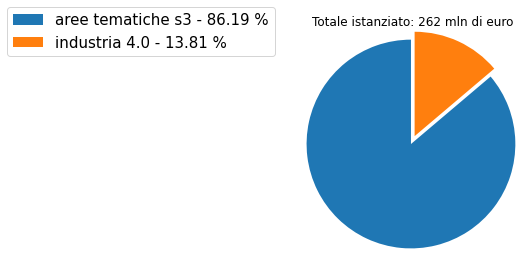

In [264]:
print("FINANZE PER PROGETTI NELLA REGIONE MARCHE\n")
pieChart(f"Totale istanziato: {int((s3_tot + ind4_tot)*1E-6)} mln di euro", ["aree tematiche s3", "industria 4.0"], [s3_tot, ind4_tot], (0.05,0.05))
plt.show()

FINANZE PER PROGETTI CON AREA TEMATICA S3



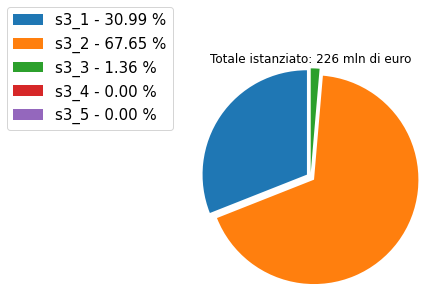

In [265]:
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {int(s3_tot*1E-6)} mln di euro",list(s3_tot_dict.keys()), list(s3_tot_dict.values()), (0.05,0.05,0.05,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



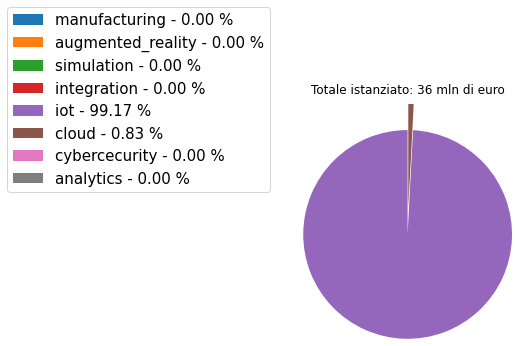

In [266]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {int(ind4_tot*1E-6)} mln di euro",list(ind4_tot_dict.keys()), list(ind4_tot_dict.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

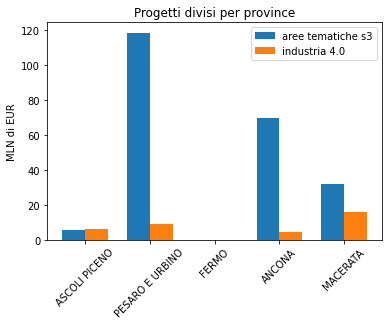

VALORI IN MILIONI DI EURO


ASCOLI PICENO:
	aree tematiche s3: 5.436193019999999
	industria 4.0: 6.142319

 PESARO E URBINO:
	aree tematiche s3: 118.67304305999997
	industria 4.0: 9.30862222

 FERMO:
	aree tematiche s3: 0.049999999999999996
	industria 4.0: 0.0

 ANCONA:
	aree tematiche s3: 69.73902919999999
	industria 4.0: 4.660785

 MACERATA:
	aree tematiche s3: 32.144049450000004
	industria 4.0: 16.1203926




In [271]:
prov = spark.sql("SELECT DEN_PROVINCIA, SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA")
province = {} # Nome provincia: [eur_s3, eur_ind4] in milioni di euro

for prov, eur in zip(prov.select("DEN_PROVINCIA").collect(), prov.select("SUM(FINANZ_TOTALE_PUBBLICO)").collect()):
    province[prov.DEN_PROVINCIA] = [eur["SUM(FINANZ_TOTALE_PUBBLICO)"]*1E-6]
    
prov = spark.sql("SELECT DEN_PROVINCIA, SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA")
for prov, eur in zip(prov.select("DEN_PROVINCIA").collect(), prov.select("SUM(FINANZ_TOTALE_PUBBLICO)").collect()):
    province[prov.DEN_PROVINCIA].append(eur["SUM(FINANZ_TOTALE_PUBBLICO)"]*1E-6)
    
for key in province.keys():
    if len(province[key]) != 2: # Si presuppone sia 1 (Fermo non s' presente nella tabella ind4)
        province[key].append(0.0)
        
labels = list(province.keys())
width = 0.35
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [val[0] for val in province.values()], width, label='aree tematiche s3')
rects2 = ax.bar(x + width/2, [val[1] for val in province.values()], width, label='industria 4.0')

ax.set_ylabel('MLN di EUR')
ax.set_title('Progetti divisi per province')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.show()
print("VALORI IN MILIONI DI EURO\n\n")
print(*[f"{prov}:\n\taree tematiche s3: {val[0]}\n\tindustria 4.0: {val[1]}\n\n" for prov, val in province.items()])

## *Per provincia*:
> * percentuali totali di s3 e ind4
> * percentuali di s3
> * percentuali di ind4

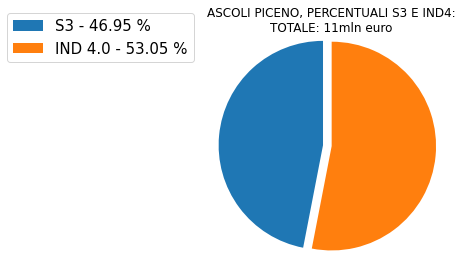

In [272]:
# Ascoli Piceno.
pieChart(f"ASCOLI PICENO, PERCENTUALI S3 E IND4:\nTOTALE: {int(sum(province['ASCOLI PICENO']))}mln euro", ["S3", "IND 4.0"], province.get("ASCOLI PICENO"), (0.1,0))

In [273]:
s3_tot_prov = {}
ind4_tot_prov = {}
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'ASCOLI%'").first()[0]
ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'ASCOLI%'").first()[0]
for key in s3_dict.keys():
    try:
        s3_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'ASCOLI%'").first()[0]
    except TypeError:
        s3_tot_prov[key] = 0.0

        
for key in ind4_dict.keys():
    try:
        ind4_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'ASCOLI%'").first()[0]
    except TypeError:
        ind4_tot_prov[key] = 0.0
        

ASCOLI PICENO: FINANZE PER PROGETTI CON AREA TEMATICA S3



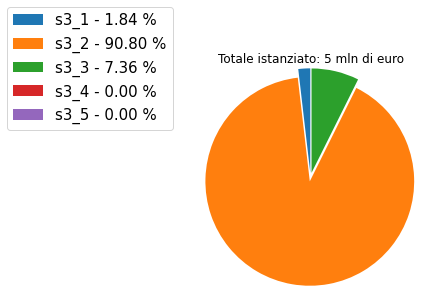

In [275]:
print("ASCOLI PICENO: FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {int(s3_tot*1E-6)} mln di euro",list(s3_tot_dict.keys()), list(s3_tot_prov.values()), (0.05,0.05,0.05,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



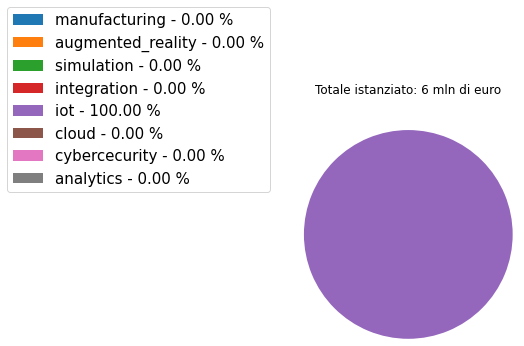

In [276]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {int(ind4_tot*1E-6)} mln di euro",list(ind4_tot_dict.keys()), list(ind4_tot_prov.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

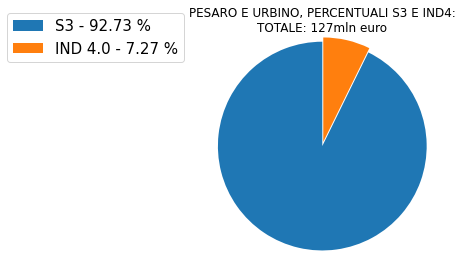

In [277]:
# PESARO E URBINO.
pieChart(f"PESARO E URBINO, PERCENTUALI S3 E IND4:\nTOTALE: {int(sum(province['PESARO E URBINO']))}mln euro", ["S3", "IND 4.0"], province.get("PESARO E URBINO"), (0,0.05))

In [278]:
s3_tot_prov = {}
ind4_tot_prov = {}
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'PESARO%'").first()[0]
ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'PESARO%'").first()[0]
for key in s3_dict.keys():
    try:
        s3_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'PESARO%'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        s3_tot_prov[key] = 0.0

        
for key in ind4_dict.keys():
    try:
        ind4_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA LIKE 'PESARO%'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        ind4_tot_prov[key] = 0.0
        

FINANZE PER PROGETTI CON AREA TEMATICA S3



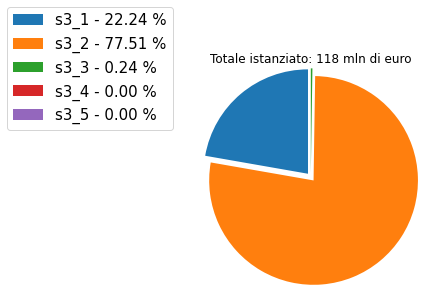

In [279]:
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {int(s3_tot*1E-6)} mln di euro",list(s3_tot_dict.keys()), list(s3_tot_prov.values()), (0.05,0.05,0.05,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



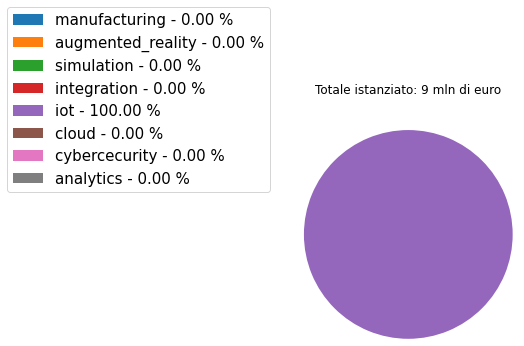

In [280]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {int(ind4_tot*1E-6)} mln di euro",list(ind4_tot_dict.keys()), list(ind4_tot_prov.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

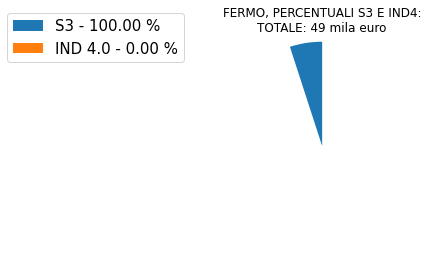

In [281]:
# FERMO.
pieChart(f"FERMO, PERCENTUALI S3 E IND4:\nTOTALE: {int(sum([el*1e3 for el in province['FERMO']]))} mila euro", ["S3", "IND 4.0"], province.get("FERMO"), (0,0), normalize = False)

In [282]:
s3_tot_prov = {}
ind4_tot_prov = {}
try:
    s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'FERMO'").first()[0]
except TypeError:
    s3_tot = 0.0
try:
    ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'FERMO'").first()[0]
except TypeError:
    ind4_tot = 0.0

for key in s3_dict.keys():
    try:
        s3_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'FERMO'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        s3_tot_prov[key] = 0.0

        
for key in ind4_dict.keys():
    try:
        ind4_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'FERMO'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        ind4_tot_prov[key] = 0.0
        

FINANZE PER PROGETTI CON AREA TEMATICA S3



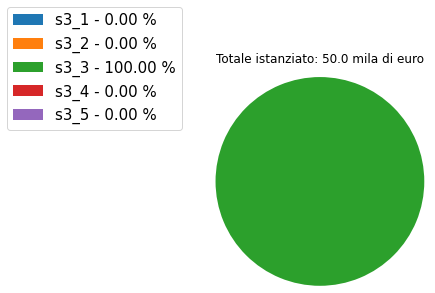

In [284]:
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {s3_tot*1E-3} mila di euro",list(s3_tot_dict.keys()), list(s3_tot_prov.values()), (0.05,0.05,0.05,0,0))
plt.show()

In [285]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {ind4_tot*1E-3} mila di euro",list(ind4_tot_dict.keys()), list(ind4_tot_prov.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



<ipython-input-263-23d94def9ef7>:5: RuntimeWarning: invalid value encountered in true_divide
  porcent = 100.*y/y.sum()
/home/hadoop_user/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3050: RuntimeWarning: invalid value encountered in true_divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

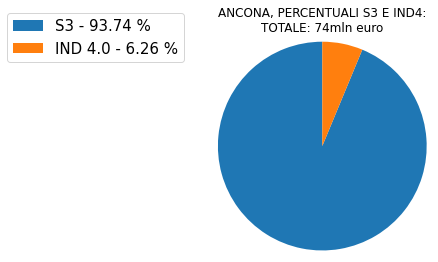

In [286]:
# ANCONA.
pieChart(f"ANCONA, PERCENTUALI S3 E IND4:\nTOTALE: {int(sum(province['ANCONA']))}mln euro", ["S3", "IND 4.0"], province.get("ANCONA"), (0,0))

In [287]:
s3_tot_prov = {}
ind4_tot_prov = {}
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ANCONA'").first()[0]
ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ANCONA'").first()[0]

for key in s3_dict.keys():
    try:
        s3_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ANCONA'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        s3_tot_prov[key] = 0.0

        
for key in ind4_dict.keys():
    try:
        ind4_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ANCONA'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        ind4_tot_prov[key] = 0.0
        

FINANZE PER PROGETTI CON AREA TEMATICA S3



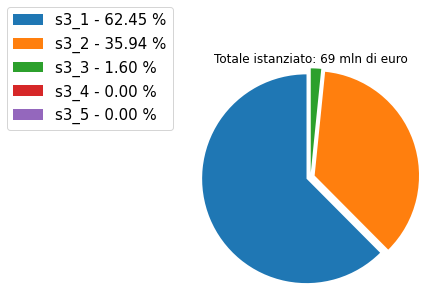

In [288]:
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {int(s3_tot*1E-6)} mln di euro",list(s3_tot_dict.keys()), list(s3_tot_prov.values()), (0.05,0.05,0.05,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



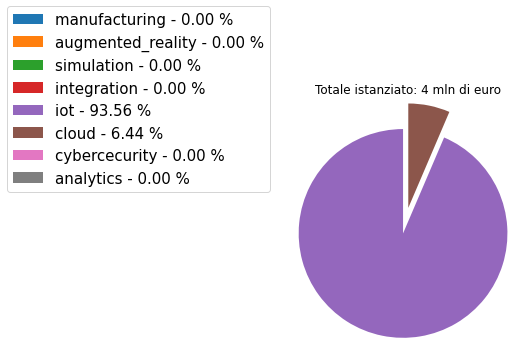

In [289]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {int(ind4_tot*1E-6)} mln di euro",list(ind4_tot_dict.keys()), list(ind4_tot_prov.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

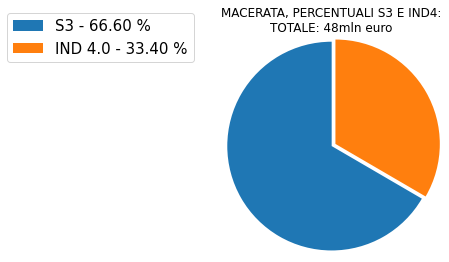

In [290]:
# MACERATA.
pieChart(f"MACERATA, PERCENTUALI S3 E IND4:\nTOTALE: {int(sum(province['MACERATA']))}mln euro", ["S3", "IND 4.0"], province.get("MACERATA"), (0,0.05))

In [ ]:
s3_tot_prov = {}
ind4_tot_prov = {}
s3_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM s3 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'MACERATA'").first()[0]
ind4_tot = spark.sql("SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM ind4 GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'MACERATA'").first()[0]

for key in s3_dict.keys():
    try:
        s3_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ASCOLI'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        s3_tot_prov[key] = 0.0

        
for key in ind4_dict.keys():
    try:
        ind4_tot_prov[key] = spark.sql(f"SELECT SUM(FINANZ_TOTALE_PUBBLICO) FROM {key} GROUP BY DEN_PROVINCIA").where("DEN_PROVINCIA = 'ASCOLI'").first()[0] * 1E-6 # milioni di euro
    except TypeError:
        ind4_tot_prov[key] = 0.0
        

In [248]:
print("FINANZE PER PROGETTI CON AREA TEMATICA S3\n")
pieChart(f"Totale istanziato: {int(s3_tot*1E-6)} mln di euro",list(s3_tot_dict.keys()), list(s3_tot_prov.values()), (0.05,0.05,0.05,0,0))
plt.show()

FINANZE PER PROGETTI CON AREA TEMATICA S3



<ipython-input-200-23d94def9ef7>:5: RuntimeWarning: invalid value encountered in true_divide
  porcent = 100.*y/y.sum()


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

In [250]:
print("FINANZE PER PROGETTI INDUSTRIA 4.0\n")
pieChart(f"Totale istanziato: {int(ind4_tot)} mln di euro",list(ind4_tot_dict.keys()), list(ind4_tot_prov.values()), explode=(0,0,0,0,0.3,0,0,0))
plt.show()

FINANZE PER PROGETTI INDUSTRIA 4.0



<ipython-input-200-23d94def9ef7>:5: RuntimeWarning: invalid value encountered in true_divide
  porcent = 100.*y/y.sum()


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 432x288 with 1 Axes>

## Opzionale!
Salvataggio datasets.

**Nota**: Cambiare i path

In [56]:
main_path = "/home/hadoop_user/Scrivania/economia_app/"
if main_path: # Solo se non vuoto
    try:
        result_dataframe.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tot") # Dataset totale
        s3_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_tematiche_s3")   # Dataset dimensioni tematiche s3
        ind4_df.repartition(1).write.option("header", True).option("delimiter", ";").csv(main_path + "dataset_industria_4.0")# Dataset industria 4.0   
    except Exception as e:
        print("C'e' stato un errore nel salvataggio: " + e)
else: print("Aggiungere il path")